In [32]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import  List, Union, Type, Callable

%matplotlib inline

BIG_SEED = 132 #random seed for later
score_metric = 'f1_macro'
label_metric = 'F1 Macro'

In [33]:
df = pd.read_csv('data.csv')

In [34]:
print(len(df))
df.head()

100


,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2


In [35]:
#This way the rare class has value 1 (for the F-score)
df.Class = df.Class - 1

# Exercise 1

## Bayesian with LCB and EI

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter,\
                                        UniformIntegerHyperparameter

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO #Random Forest
from smac.facade.smac_bo_facade import SMAC4BO   #Bayesian
#from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer import acquisition

In [37]:
def optimizer(model_type :str, 
              config_space :Type[ConfigurationSpace],
              obj_function :Type[Callable],
              acquisition_type :str,
              n_iter :int = 10,
              init_points :int = 0,
              seed :int=None) -> Union[Type[SMAC4BO], Type[SMAC4HPO]]:
    """
    It is just a small wrapper to simplify and make more intuitive the SMAC optimization
    for ML algorithms for this assignment.
    PARAMETERS
    ----------
    @model_type       can be 'bo' for Bayesian optimization or 'rf' for RandomForest
    @config_space     an object of type ConfigSpace containing information
                      regarding the hyperparameters
    @obj_function     the objective function that needs to be minimized 
    @acquisition_type can be 'LCB' or 'EI' and indicated the type of acquisition function
                      to be used, if the value is different from 'LCB' or 'EI' it will
                      use the default acquisition function of SMAC
    @n_iter           number of iterations to do, defaults to 10 iterations
    @init_points      number of initial points, defaults to 0 initial points
    @seed             fix the seed for most of the randomness to have reproducible results
    
    RETURN
    ------
    either an optimized SMAC4BO object if 'bo' model_type was chosen or an
    optimized SMAC4HPO object if 'rf' model_type was chosen
    """
    #create the scenario required by SMAC optimizers
    scenario = Scenario(scenario={"run_obj": "quality",    # we optimize quality
                                  "runcount-limit": n_iter,# number iterations
                                  "cs": config_space,      # configuration space
                                  "output_dir": "logs",    # create a log folder named 'logs'
                                  "deterministic": "true"})
    
    #create init_points random points, fixing the seed if necessary
    cs.seed(seed)
    init = cs.sample_configuration(init_points)
    cs.seed(None) #remove the seed from configuration space
    
    #chose the acquisition function
    if acquisition_type == 'LCB':
        print('Using LCB acquisition Function')
        _acquistion = acquisition.LCB
    elif acquisition_type == 'EI':
        print('Using EI acquisition Function')
        _acquistion = acquisition.EI
    else:
        print('Using SMAC Default acquisition Function')
        _acquistion = None
        
    #chose and optimize the SMAC model
    if model_type == 'bo':
        #use SMAC4BO
        smac = SMAC4BO(scenario=scenario, tae_runner=obj_function, 
                       rng=np.random.RandomState(seed),
                       initial_design=None, 
                       initial_design_kwargs={'max_config_fracs':init_points/n_iter},
                       initial_configurations=init, 
                       acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    if model_type == 'rf':
        #use SMAC4HPO
        smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function, 
                        rng=np.random.RandomState(seed),
                        initial_design=None, 
                        initial_design_kwargs={'max_config_fracs':init_points/n_iter},
                        initial_configurations=init, 
                        acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    #in case model_type was neither bo nor rf
    raise ValueError("Model type can only 'bo' or 'rf'")

In [38]:
#SMAC needs a Configuration Space where it will search for the hyperparameters
cs = ConfigurationSpace()

#define the domain of each hyperparameter
lr = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9)

#add the hyperparameters to the configuration space
cs.add_hyperparameters([lr, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [39]:
def MLP_score_1(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    #rseed = int(conf['momentum']*conf['learning_rate_init']*5000)
    rseed = BIG_SEED
    MLPclf = MLPClassifier(hidden_layer_sizes=(4,2,), momentum = conf['momentum'],
                          learning_rate_init = conf['learning_rate_init'],
                          random_state=rseed)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score)  # it needs to Minimize it!

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Using LCB acquisition Function
0.08028135089132196 0.38552141981754795 0.4625094599243206
0.04430300876374074 0.8696975470069911 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4814) is better than incumbent (0.5375) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08028135089132196 -> 0.04430300876374074
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.38552141981754795 -> 0.8696975470069911


0.0845773877536592 0.3849918837749665 0.49511910904712764
0.0803514512536536 0.7548643234302469 0.48160990712074303
0.08214374064161822 0.8241504085662323 0.4845046439628483


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.04472775629385976 0.870744408787714 0.49416150670794645


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.044022368655118126 0.8683731433033388 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.04414704374479589 0.7893378126629708 0.5144392844857242


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.04297416548372798 0.8691874177835418 0.4898486412108703


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.08933701626205946 0.10015306501934713 0.5011351909184727


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.08896983933156027 0.6177555306382105 0.4898778809769522


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.046553873986899294 0.8685042081977293 0.4775455796353629


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.04375555249879079 0.7922292194722599 0.5144392844857242


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.09029349365232536 0.10025747048826858 0.4491438437723267


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.08803810920974404 0.10001666703108464 0.4898778809769522


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.04382390037993037 0.10477841042588923 0.48999484004127963


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.06012890960903105 0.7248463890716347 0.45929308565531474


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.08589924675187095 0.41166855664283086 0.48214469998525733


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.018734533993409436 0.13232420896902017 0.49983316133470934


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.02031481211260528 0.13197637987260522 0.44223756979174944


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.017738870397796303 0.13242809042480103 0.4757619539043688


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.01900749314949398 0.8997260468733582 0.46526819499729716


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.08363069553816885 0.1586942244047736 0.5424802201582388


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4575) is better than incumbent (0.4814) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.04430300876374074 -> 0.08363069553816885
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8696975470069911 -> 0.1586942244047736
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4575


0.08317668263925945 0.12915648785463654 0.4654041967664259


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4575


0.0838642535177591 0.16177856618279948 0.4683281733746131


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4575
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 2
INFO:smac.stats.stats.Stats:#Target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 79.30 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 19.74 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.08363069553816885
  momentum, Value: 0.1586942244047736

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.457520


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.08363069553816885
  momentum, Value: 0.1586942244047736



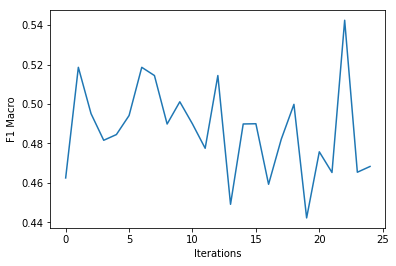

In [40]:
#Use bo and LCB
smac_LCB = optimizer('bo', cs, obj_function=MLP_score_1, 
                     acquisition_type='LCB', n_iter=25, 
                     init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_LCB.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Using EI acquisition Function
0.08028135089132196 0.38552141981754795 0.4625094599243206
0.04430300876374074 0.8696975470069911 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4814) is better than incumbent (0.5375) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08028135089132196 -> 0.04430300876374074
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.38552141981754795 -> 0.8696975470069911


0.0845773877536592 0.3849918837749665 0.49511910904712764
0.0803514512536536 0.7548643234302469 0.48160990712074303
0.08214374064161822 0.8241504085662323 0.4845046439628483


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.04438004844581235 0.8702971205339126 0.4787375300997592


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.022576230575740527 0.12245928843017025 0.4821508427932577


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4814


0.044267878635572966 0.8691734082781671 0.5298632610939114


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4701) is better than incumbent (0.4814) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.04430300876374074 -> 0.044267878635572966
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8696975470069911 -> 0.8691734082781671
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044220751957514425 0.8695595862700376 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044274211371970726 0.8679327068281121 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044342655507437725 0.8687878938540409 0.4904591418213709


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044267878635572966 0.8723521531474396 0.5298632610939114


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.04425116473111475 0.8709277859304597 0.5144392844857242


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.04426440293284462 0.8734176852265357 0.5298632610939114


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.04429303440283636 0.8727733880752909 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.04413861115858119 0.8741176850835773 0.5111304609563124


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.0442400782837238 0.8731522345462731 0.5144392844857242


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.04384930185065958 0.8673189764015007 0.4978379772961817


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044227636060031675 0.2131072524792179 0.5144392844857242


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.04404773205970428 0.212437945949284 0.5186059511523908


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044267878635572966 0.8737516855898497 0.5298632610939114


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.07353899064334973 0.8908117116471009 0.45556501547987616


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.08797972942877356 0.7122861692955099 0.5011351909184727


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.043952503998206806 0.15002908605644946 0.4746362229102167


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701


0.044116127062687825 0.23333060053264157 0.4866860165118679


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4701
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 2
INFO:smac.stats.stats.Stats:#Target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 99.10 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 21.90 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.044267878635572966
  momentum, Value: 0.8691734082781671

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.470137


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.044267878635572966
  momentum, Value: 0.8691734082781671



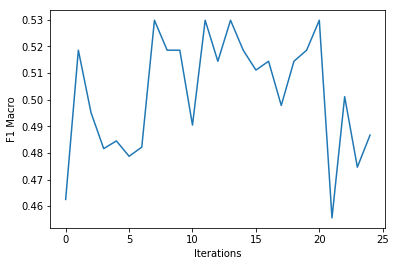

In [41]:
#Use bo and EI
smac_EI = optimizer('bo', cs, obj_function=MLP_score_1, 
                    acquisition_type='EI', n_iter=25, 
                    init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_EI.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

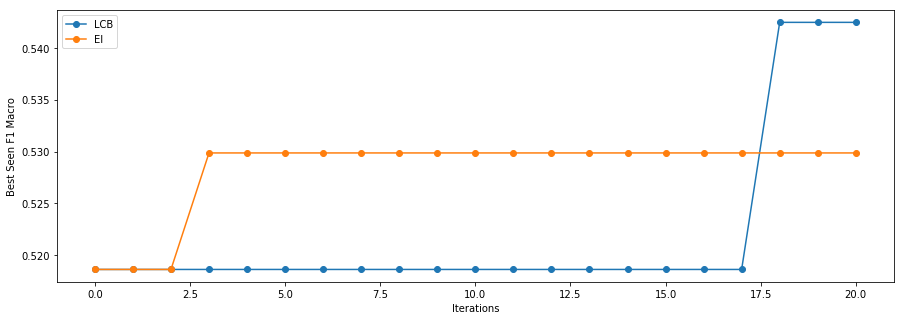

In [42]:
#Compare the two models removing the initial 5 points keeping only the best of them.
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1])[4:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1])[4:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

## Grid and Randomized Search

In [43]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time

In [44]:
#create the configuration grid with 5 element for each hyperparameter
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5)}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1) #n_jobs=-1 parallelize the computation

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'learning_rate_init': 0.05500000000000001, 'momentum': 0.1}
Training Completed in 6.511s


Best Score 0.5151140350877194


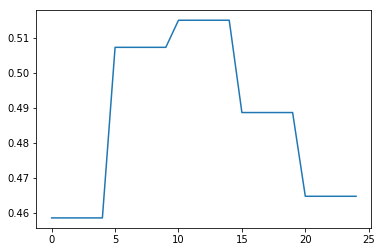

In [45]:
print("Best Score", np.max(MLP_GS.cv_results_['mean_test_score']))
plt.plot(MLP_GS.cv_results_['mean_test_score'])
plt.show()

In [46]:
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9)}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=25, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.3938775510204082, 'learning_rate_init': 0.09081632653061225}
Training Completed in 6.999s


Best Score 0.5412449260405917


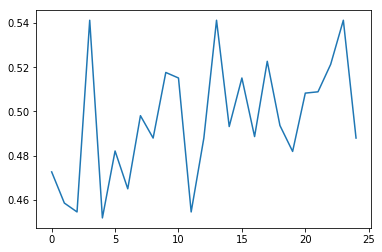

In [47]:
print("Best Score", np.max(MLP_RS.cv_results_['mean_test_score']))
plt.plot(MLP_RS.cv_results_['mean_test_score'])
plt.show()

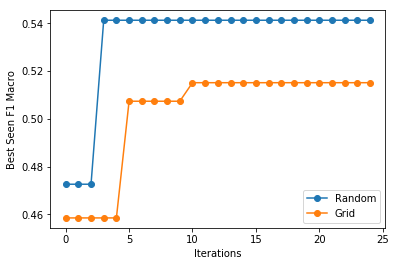

In [48]:
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

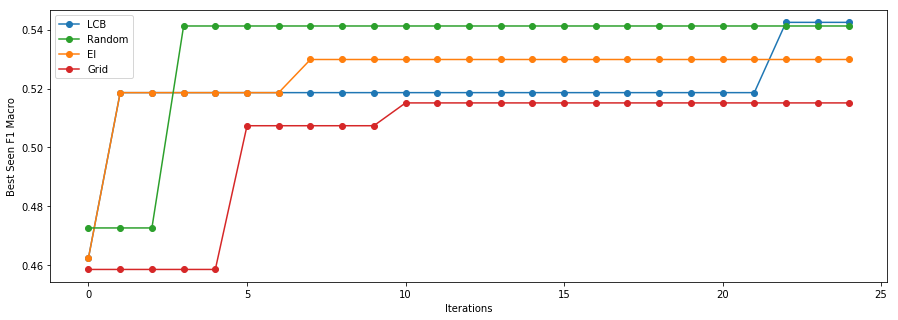

In [50]:
plt.figure(figsize=(15,5))
lcb, = plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1]), 'o-')
ei,  = plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1]), 'o-')
rs,  = plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
gs,  = plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend([lcb,rs,ei,gs],['LCB','Random','EI','Grid']) #need to change order based on the score
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

# Exercise 2

## Random Forest with LBC and EI

In [51]:
hidden1 = UniformIntegerHyperparameter('h1',1,5)
hidden2 = UniformIntegerHyperparameter('h2',1,5)

cs.add_hyperparameters([hidden1, hidden2])

[h1, Type: UniformInteger, Range: [1, 5], Default: 3,
 h2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [52]:
def MLP_score_2(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    #rseed = int(conf['momentum']*conf['learning_rate_init']*5000)
    rseed = BIG_SEED
    MLPclf = MLPClassifier(hidden_layer_sizes=(conf['h1'],conf['h2'],), 
                           momentum = conf['momentum'],
                           learning_rate_init = conf['learning_rate_init'],
                           random_state=rseed)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score)  # it needs to Minimize it!

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Using EI acquisition Function


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4224) is better than incumbent (0.5317) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 4 -> 5
INFO:smac.intensification.intensification.Intensifier:  h2 : 1 -> 3
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.029413959922052688 -> 0.03169391571725954
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8637144060672871 -> 0.6495777204192075
INFO:smac.intensification.intensification.Intensifier:Challenger (0.3950) is better than incumbent (0.4224) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 5
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.03169391571725954 -> 0.03260778141029023
INFO:smac.intensification.intensification.Intensifier:  m

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3917
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  h1, Value: 5
  h2, Value: 5
  learning_rate_init, Value: 0.03715146196388453
  momentum, Value: 0.8021411156724509



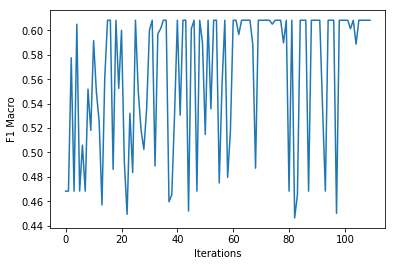

In [53]:
#Use rf and EI
smac_rf_EI = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='EI', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_rf_EI.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Using LCB acquisition Function


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4224) is better than incumbent (0.5317) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 4 -> 5
INFO:smac.intensification.intensification.Intensifier:  h2 : 1 -> 3
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.029413959922052688 -> 0.03169391571725954
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8637144060672871 -> 0.6495777204192075
INFO:smac.intensification.intensification.Intensifier:Challenger (0.3950) is better than incumbent (0.4224) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 5
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.03169391571725954 -> 0.03260778141029023
INFO:smac.intensification.intensification.Intensifier:  m

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3381
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  h1, Value: 3
  h2, Value: 4
  learning_rate_init, Value: 0.05884355058994059
  momentum, Value: 0.2514496915292822



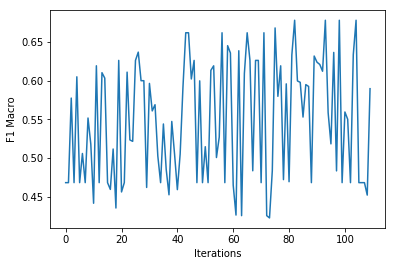

In [54]:
#Use rf and LCB
smac_rf_LCB = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='LCB', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_rf_LCB.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

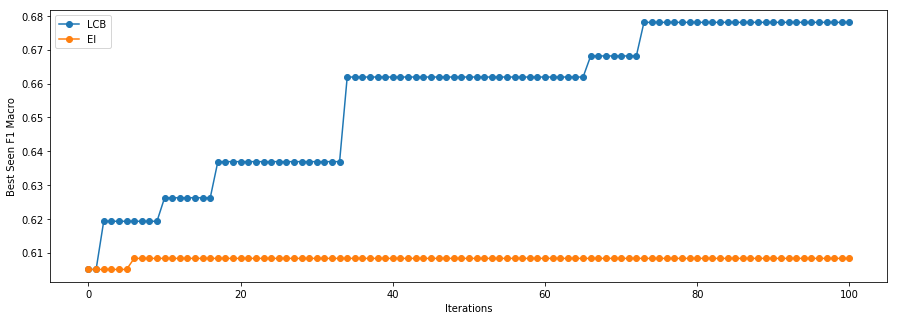

In [55]:
#Compare the two models removing the initial 5 points keeping only the best of them.
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1])[9:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1])[9:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

## Random and Grid Search

In [56]:
#create the configuration grid with 5 element for each hyperparameter
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5),
             'hidden_layer_sizes':[(1,1), (1,5), (3,3), (5,1), (5,5)]}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_, "-> score", MLP_GS.best_score_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'hidden_layer_sizes': (3, 3), 'learning_rate_init': 0.05500000000000001, 'momentum': 0.1} -> score 0.6278881333235049
Training Completed in 24.974s


In [57]:
hidden =[(i, j) for i in range(1,6) for j in range(1,6)]        
        
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9),
              'hidden_layer_sizes':hidden}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=110, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_, "-> score", MLP_RS.best_score_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.7040816326530612, 'learning_rate_init': 0.032040816326530615, 'hidden_layer_sizes': (3, 4)} -> score 0.6769752751977984
Training Completed in 26.349s


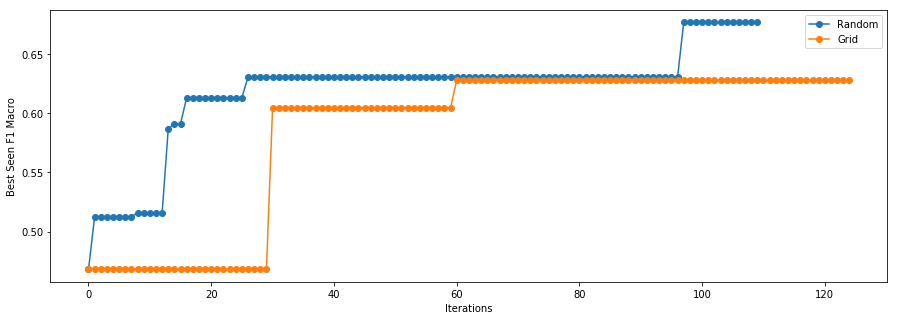

In [58]:
plt.figure(figsize=(15,5))
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

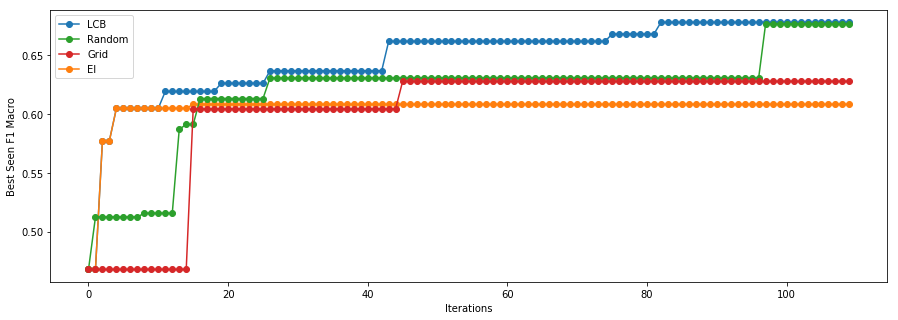

In [60]:
plt.figure(figsize=(15,5))
lcb, = plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1]), 'o-', label='LCB')
ei, = plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1]), 'o-', label='EI')
rs, = plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-', label='Random')
gs, = plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score'])[15:], 'o-', label='Grid')

plt.legend([lcb,rs,gs,ei], ['LCB','Random','Grid','EI'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()